<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Pneumonia_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia Classification Challenge by Segmind

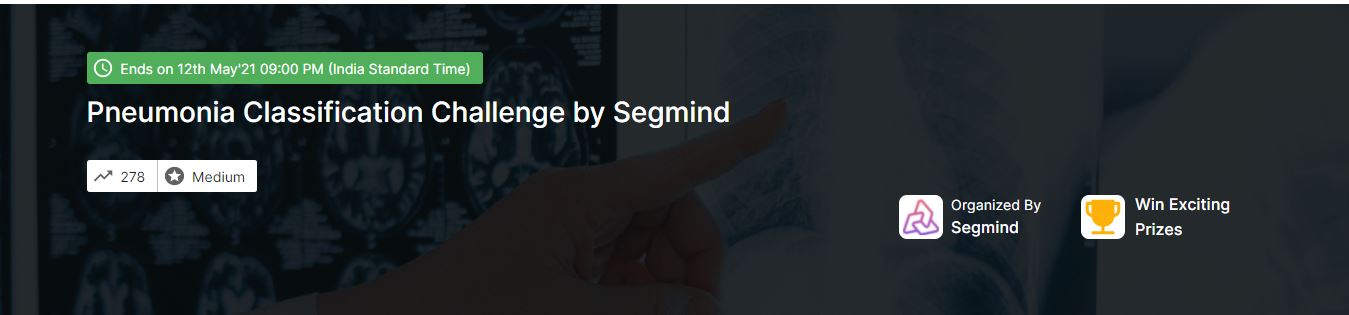

## About the Dataset

* It consists of 2425 CXRs for training and 606 CXRs for testing. Training data: 1145 Pneumonia CXRs and 1280 Normal CXRs. Every CXR is a 1024 X 1024 image in the PNG format.

* The labels for each CXR were extracted using an NLP label extractor from corresponding radiology reports.


 

Download the dataset from here: https://drive.google.com/file/d/1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY/view?usp=sharing

 

From the above link you will be able to download a zip file named detect_trees_near_electric_wires.zip’. After you extract this zip file, you will get four files:

* train - contains all the images that are to be used for training your model.
 

* test - contains 600+ images. For these images you are required to make predictions whether  the x-ray image is disease
 

* test.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you submit are with their image’s filename in the same order as given in this file.
 

* sample_submission: This is a csv file that contains the sample submission for the data sprint.

**Note: The header of the predicted values in the submission file to be ‘label’ else it will throw an error. For reference check sample submission file downloaded from above link.**

## Problem Statement
 
Pneumonia Classification in Chest X-Rays (CXRs) is organized by Segmind. As you maybe aware, "Pneumonia killed more than 808,000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years. People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems." — WHO 

 

While prevalent, diagnosing pneumonia in a CXR accurately is difficult. Expert radiologists are required to review the CXR and also require confirmation through clinical examinations. You are tasked to classify CXRs with pneumonia from their normal CXR counterparts, using machine learning and computer vision techniques.

## Evaluation Metrics : F1_Score

## Download Images

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY',
                                    dest_path='content/pneumonia_dataset.zip',
                                    unzip=True)

Unzipping...Done.


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Building Montages of the Training Images

In [ ]:
from imutils import build_montages
from imutils import paths
import argparse
import random
import cv2

In [ ]:
!unzip "/content/drive/MyDrive/AV_Hack/pneumonia_dataset.zip" -d "/content/content"

Archive:  /content/drive/MyDrive/AV_Hack/pneumonia_dataset.zip
   creating: /content/content/pneumonia_dataset/
  inflating: /content/content/pneumonia_dataset/sample_submission.csv  
   creating: /content/content/pneumonia_dataset/test/
  inflating: /content/content/pneumonia_dataset/test/CXR_test_1.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_10.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_100.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_101.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_102.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_103.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_104.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_105.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_106.png  
  inflating: /content/content/pneumonia_dataset/test/CXR_test_107.png  
  inflating: /content/content/pneumonia_datas

## grab the paths to the images, then randomly select a sample of them

In [ ]:
imagePaths = list(paths.list_images("/content/content/pneumonia_dataset/train/"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:21]

## Read a sample imges and find the shape of the images

In [ ]:
img = cv2.imread(imagePaths[0])
img.shape

(1024, 1024, 3)

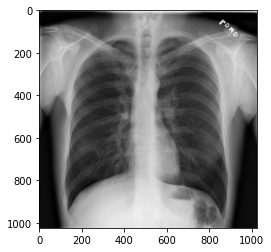

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [ ]:
# initialize the list of images
images = []
# loop over the list of image paths
for imagePath in imagePaths:
	# load the image and update the list of images
	image = cv2.imread(imagePath)
	images.append(image)
# construct the montages for the images
montages = build_montages(images, (224, 224), (7, 3))

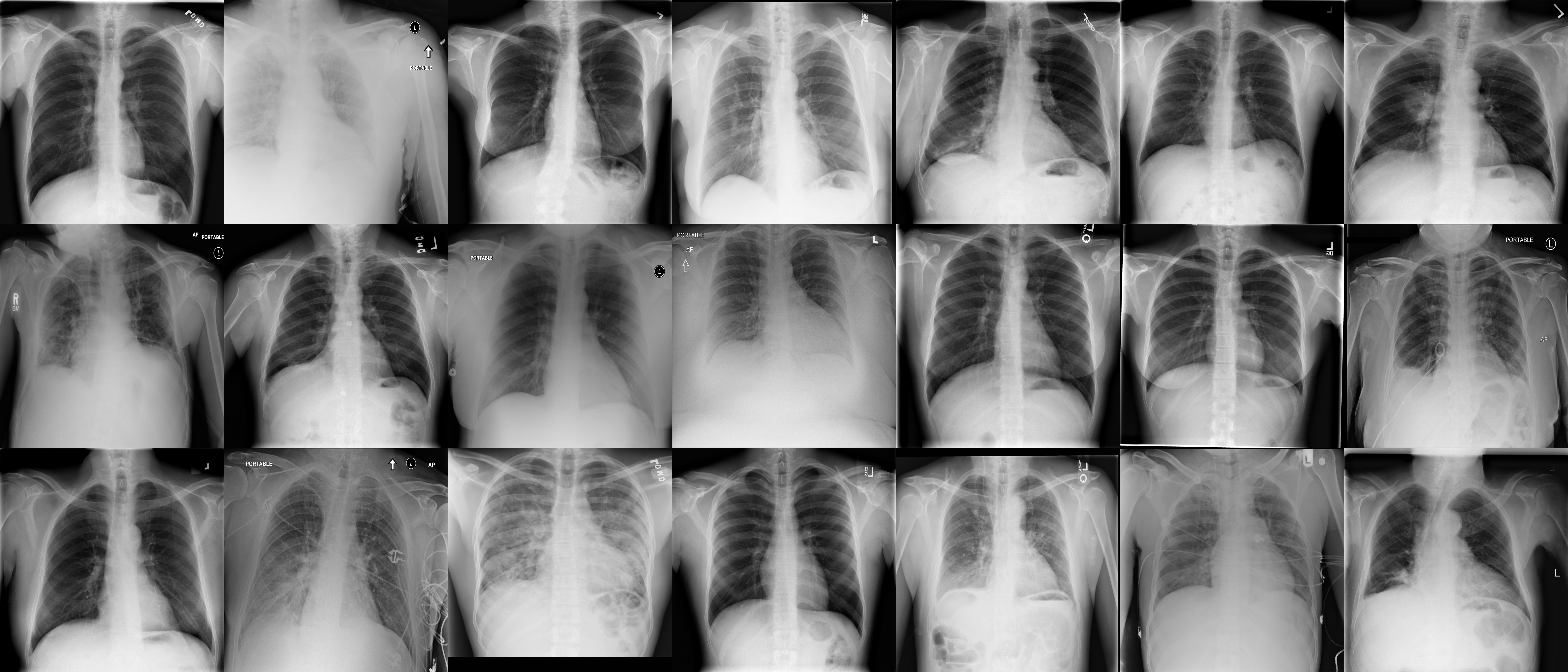

In [ ]:
# loop over the montages and display each of them
from google.colab.patches import cv2_imshow
for montage in montages:
	cv2_imshow(montage)

## Import Required Libraries

In [3]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import glob
#
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
from fastai.callbacks import *
#

import warnings
warnings.filterwarnings('ignore')

## Prepare Training File

In [4]:
image_folder = os.listdir("/content/content/pneumonia_dataset/train")
filename = []
label = []
for folder in image_folder:
  for image_name in os.listdir(os.path.join("/content/content/pneumonia_dataset/train",folder)):
    filename.append("train/"+folder+"/"+image_name)
    label.append(folder)


## Preapare a Dataframe

In [5]:
train_df = pd.DataFrame({'filename':filename,'label':label})
train_df.head()

filename      label
0   train/pneumonia/CXR_train_716.png  pneumonia
1  train/pneumonia/CXR_train_1506.png  pneumonia
2  train/pneumonia/CXR_train_2415.png  pneumonia
3  train/pneumonia/CXR_train_1157.png  pneumonia
4  train/pneumonia/CXR_train_2330.png  pneumonia

## Visualize the Labels

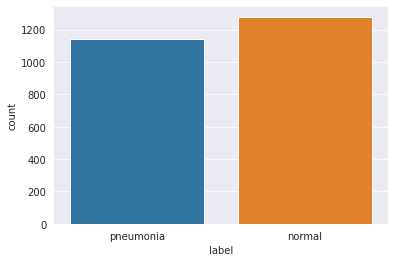

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_df)

* Labels are balanced - no scenario of imbalance

## Export the dataframe to a .csv file

In [6]:
train_df.to_csv("/content/content/pneumonia_dataset/Training.csv",index=False)

## Prepare Data

In [7]:
path ='/content/content/pneumonia_dataset/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '/content/content/pneumonia_dataset/Training.csv')
        .split_by_rand_pct(0)              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/content/pneumonia_dataset/test')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

## Show Data

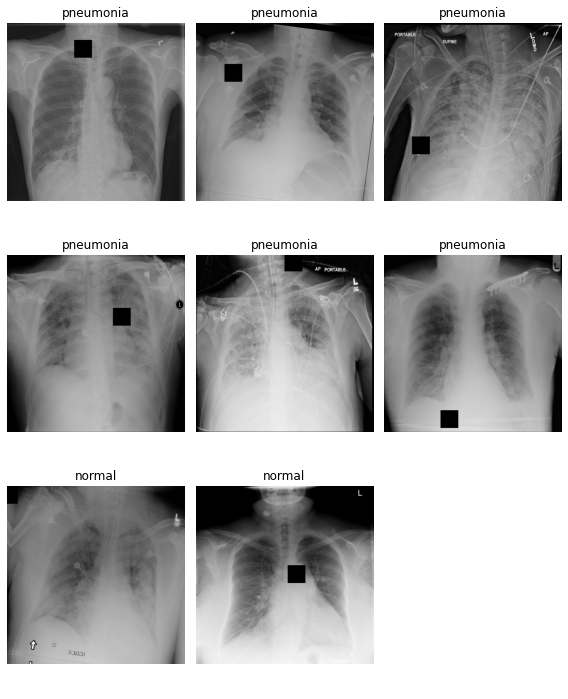

In [8]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

## print the target classes

In [9]:
val=data.classes
print(f"The number of target class : {data.c} and the respective target classes are a: {data.classes}")

The number of target class : 2 and the respective target classes are a: ['normal', 'pneumonia']


## Data Image Definition

In [10]:
data

ImageDataBunch;

Train: LabelList (2425 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/content/pneumonia_dataset;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/content/pneumonia_dataset;

Test: LabelList (606 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: EmptyLabelList
,,,,
Path: /content/content/pneumonia_dataset

## Define F1 metrics 

* When we care more about minimizing false positives than minimizing false negatives, we would want to select a beta value of < 1 for the F-beta score. precision would be given more weight than recall in this scenario

* When the priority is to minimize false negatives, we would want to select a beta value of >1 for the F-beta score. Recall would be considered more important than precision in this scenario. 

In [12]:
fscore = FBeta(average='macro', beta=2.0)

In [ ]:
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy,fscore])

In [ ]:
learn2 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy,fscore])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn2.fit_one_cycle(1)

In [17]:
path= '/content/content/pneumonia_dataset/'
k= '/content/content/pneumonia_dataset/Training.csv'
p ='/content/content/pneumonia_dataset/test.csv'
#
train=pd.read_csv(k)
test=pd.read_csv(p)

In [18]:
train.head()

filename      label
0   train/pneumonia/CXR_train_716.png  pneumonia
1  train/pneumonia/CXR_train_1506.png  pneumonia
2  train/pneumonia/CXR_train_2415.png  pneumonia
3  train/pneumonia/CXR_train_1157.png  pneumonia
4  train/pneumonia/CXR_train_2330.png  pneumonia

In [ ]:
test.head()

filename
0  CXR_test_519.png
1  CXR_test_578.png
2  CXR_test_359.png
3  CXR_test_573.png
4  CXR_test_471.png

## Set the Path

In [13]:
np.random.seed(1786)
ROOT = "/content/content/pneumonia_dataset"

In [16]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

## Define a Callback function to save the best model

In [ ]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

## Resnet152

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Better model found at epoch 0 with error_rate value: 0.3486842215061188.


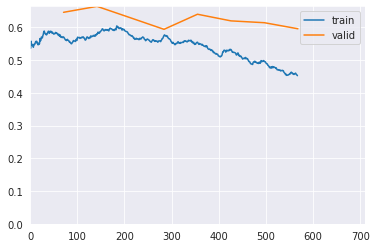

Better model found at epoch 2 with error_rate value: 0.29605263471603394.
Better model found at epoch 4 with error_rate value: 0.28947368264198303.
Better model found at epoch 7 with error_rate value: 0.2697368562221527.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.2631579041481018.


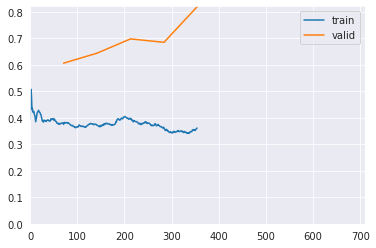

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.2697368562221527.


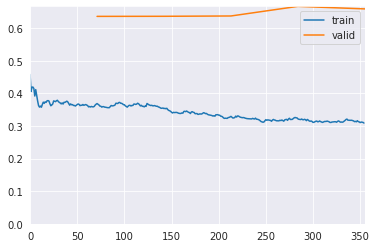

Better model found at epoch 3 with error_rate value: 0.2631579041481018.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.2631579041481018.


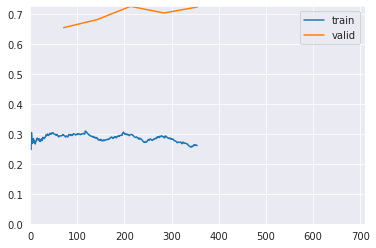

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.2631579041481018.


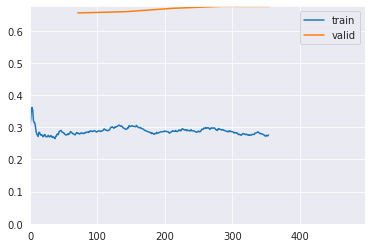

Better model found at epoch 4 with error_rate value: 0.2565789520740509.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.32894736528396606.


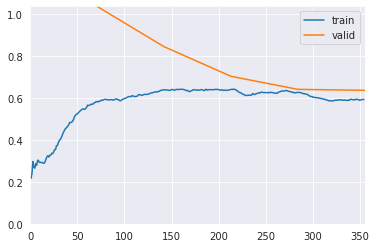

Better model found at epoch 4 with error_rate value: 0.32236841320991516.


F1 score for this fold  0.6643429766469153


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.21052631735801697.


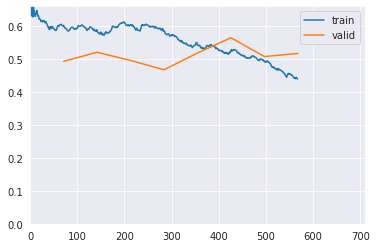

Better model found at epoch 2 with error_rate value: 0.20394736528396606.
Better model found at epoch 3 with error_rate value: 0.19736842811107635.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.21052631735801697.


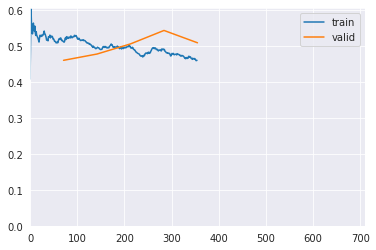

Better model found at epoch 2 with error_rate value: 0.19736842811107635.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.18421052396297455.


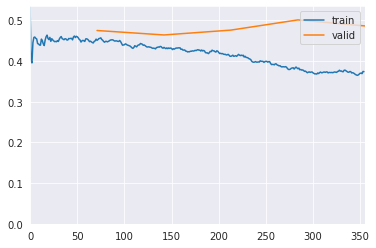

Better model found at epoch 0 with error_rate value: 0.19736842811107635.


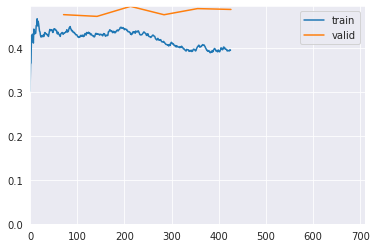

Better model found at epoch 1 with error_rate value: 0.18421052396297455.
Better model found at epoch 3 with error_rate value: 0.17763157188892365.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.21052631735801697.


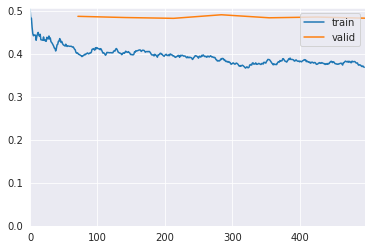

Better model found at epoch 1 with error_rate value: 0.20394736528396606.
Better model found at epoch 4 with error_rate value: 0.19078947603702545.
Epoch 6: early stopping


Better model found at epoch 0 with error_rate value: 0.4802631437778473.


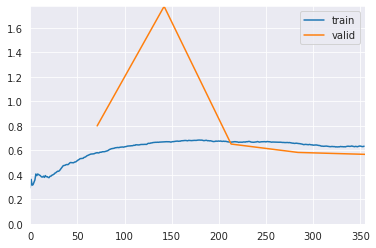

Better model found at epoch 1 with error_rate value: 0.42763158679008484.
Better model found at epoch 2 with error_rate value: 0.42105263471603394.
Better model found at epoch 3 with error_rate value: 0.28947368264198303.
Better model found at epoch 4 with error_rate value: 0.2565789520740509.


F1 score for this fold  0.7567371568137815


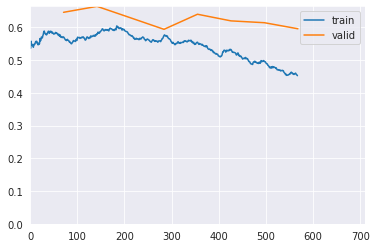

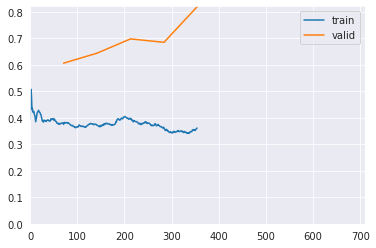

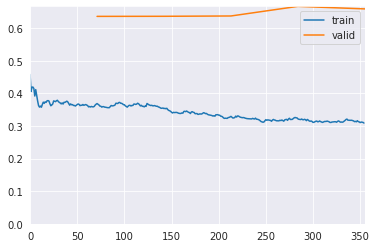

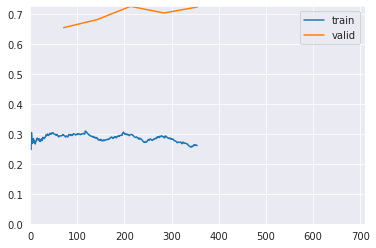

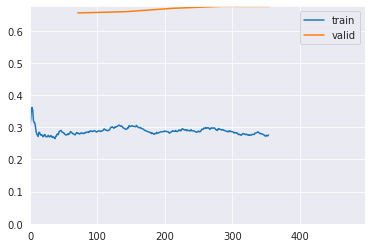

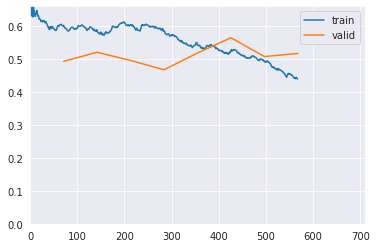

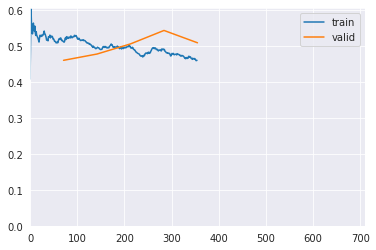

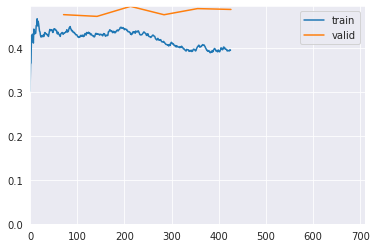

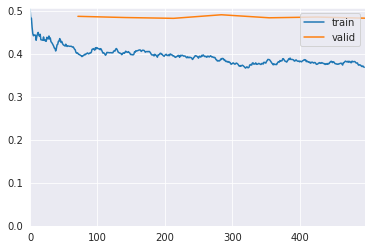

In [24]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.resnet152, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


In [ ]:
test_df.head()

filename
0  CXR_test_519.png
1  CXR_test_578.png
2  CXR_test_359.png
3  CXR_test_573.png
4  CXR_test_471.png

In [25]:
sub = test_df[["filename"]]
sub["label"] = np.argmax(test_preds, axis=1)

In [ ]:
val

['normal', 'pneumonia']

In [26]:
sub['label'] = sub['label'].apply(lambda x : val[x])

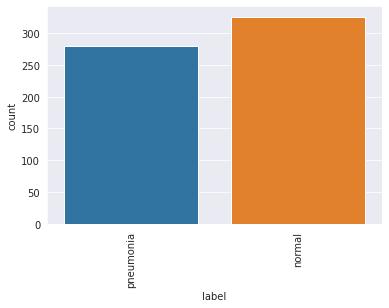

In [ ]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.show()

In [ ]:
sub.to_csv("submission_resnet152.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_resnet152.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Submission successful! Your score is 71.95899139518333.**

## Densenet121

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Better model found at epoch 0 with error_rate value: 0.33552631735801697.


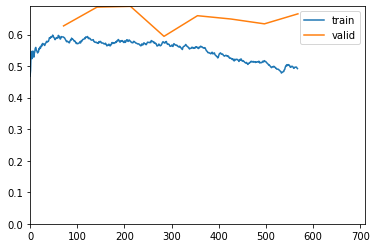

Better model found at epoch 3 with error_rate value: 0.2763157784938812.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.2763157784938812.


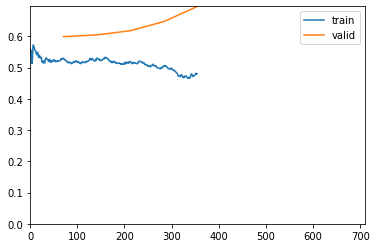

Better model found at epoch 1 with error_rate value: 0.2631579041481018.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.28289473056793213.


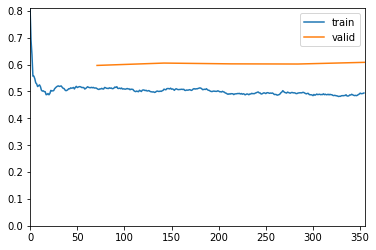

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.29605263471603394.


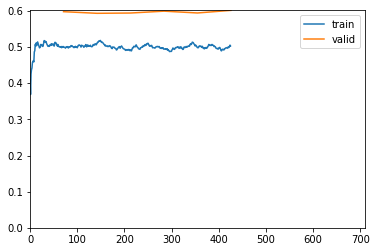

Better model found at epoch 1 with error_rate value: 0.2763157784938812.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.2763157784938812.


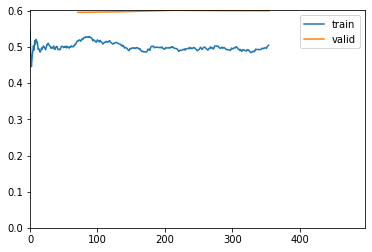

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.40789473056793213.


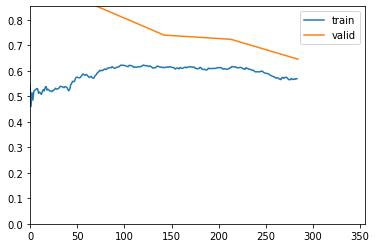

Better model found at epoch 2 with error_rate value: 0.3684210479259491.
Better model found at epoch 3 with error_rate value: 0.30921053886413574.


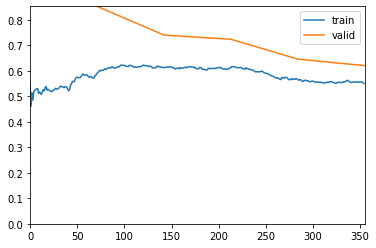

F1 score for this fold  0.6973684210526315


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.25.


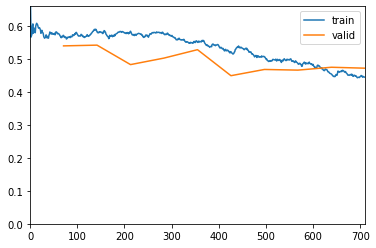

Better model found at epoch 2 with error_rate value: 0.19736842811107635.
Better model found at epoch 5 with error_rate value: 0.17105263471603394.
Epoch 9: early stopping


Better model found at epoch 0 with error_rate value: 0.17763157188892365.


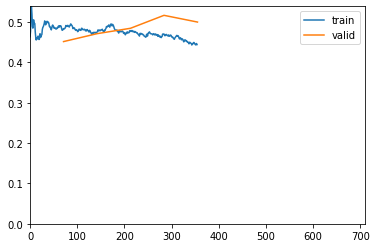

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.18421052396297455.


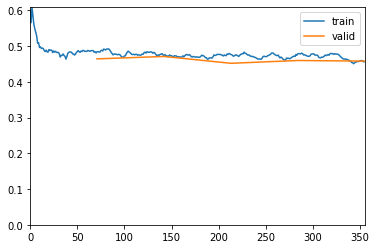

Better model found at epoch 0 with error_rate value: 0.19078947603702545.


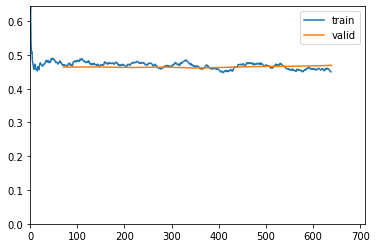

Better model found at epoch 2 with error_rate value: 0.17763157188892365.
Epoch 8: early stopping


Better model found at epoch 0 with error_rate value: 0.17763157188892365.


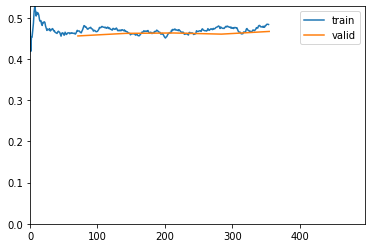

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.44736841320991516.


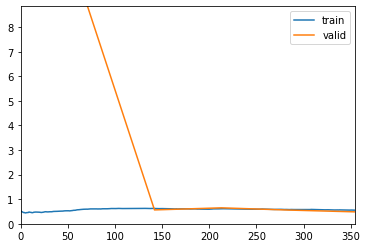

Better model found at epoch 1 with error_rate value: 0.2763157784938812.
Better model found at epoch 4 with error_rate value: 0.18421052396297455.


F1 score for this fold  0.8156299840510366


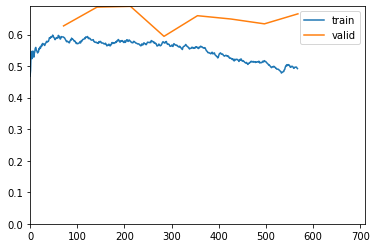

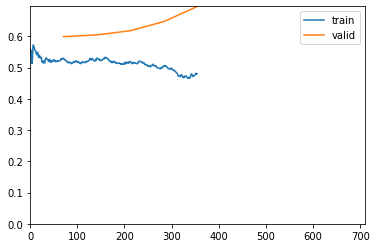

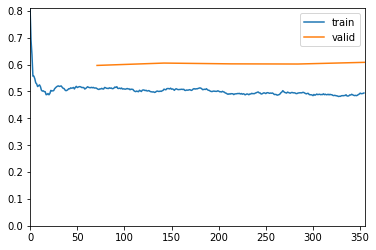

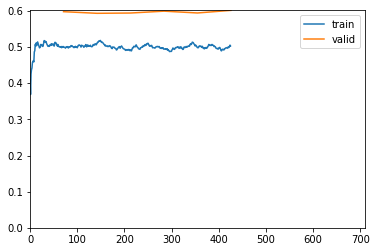

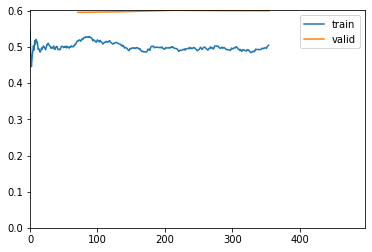

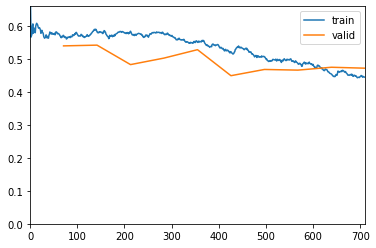

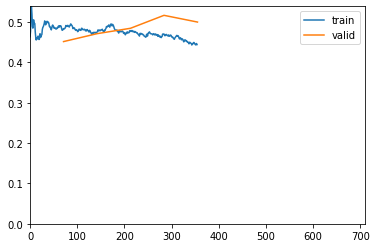

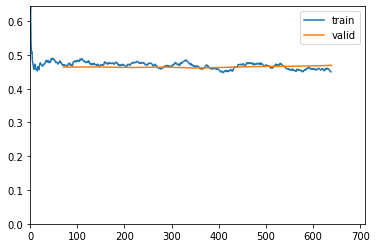

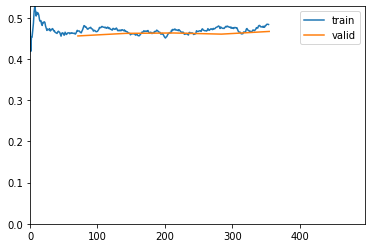

In [19]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.densenet121, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)

## Densenet169

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


Better model found at epoch 0 with error_rate value: 0.3618420958518982.


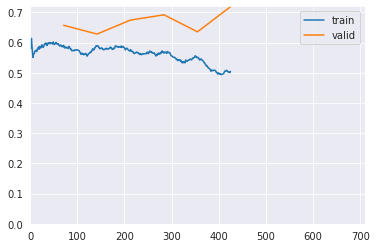

Better model found at epoch 1 with error_rate value: 0.32236841320991516.
Better model found at epoch 2 with error_rate value: 0.30263158679008484.
Better model found at epoch 5 with error_rate value: 0.28289473056793213.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.28947368264198303.


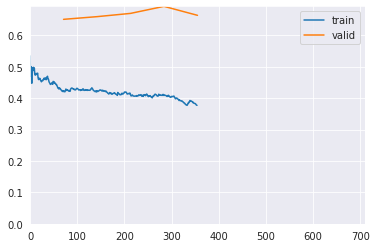

Better model found at epoch 1 with error_rate value: 0.2763157784938812.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.30921053886413574.


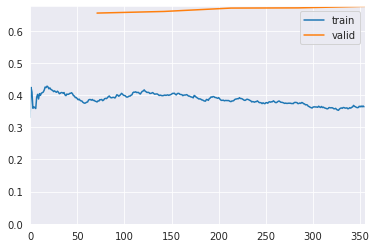

Better model found at epoch 1 with error_rate value: 0.2763157784938812.
Better model found at epoch 3 with error_rate value: 0.2697368562221527.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.28289473056793213.


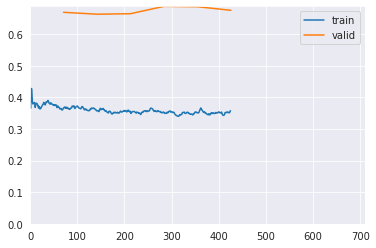

Better model found at epoch 1 with error_rate value: 0.2763157784938812.
Better model found at epoch 3 with error_rate value: 0.2697368562221527.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.28947368264198303.


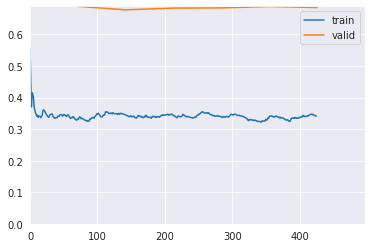

Better model found at epoch 1 with error_rate value: 0.2631579041481018.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.4013157784938812.


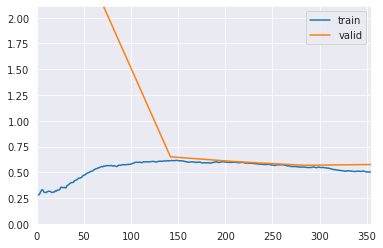

Better model found at epoch 1 with error_rate value: 0.3881579041481018.
Better model found at epoch 2 with error_rate value: 0.29605263471603394.
Better model found at epoch 4 with error_rate value: 0.2631579041481018.


F1 score for this fold  0.7041397853140585


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.23026315867900848.


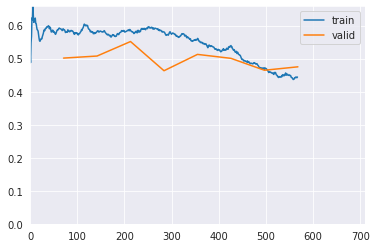

Better model found at epoch 6 with error_rate value: 0.20394736528396606.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.23026315867900848.


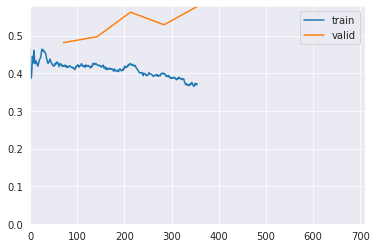

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.23026315867900848.


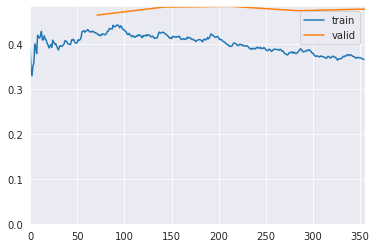

Better model found at epoch 1 with error_rate value: 0.21052631735801697.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.21710526943206787.


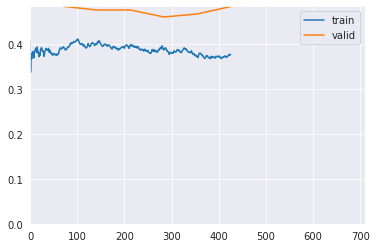

Better model found at epoch 3 with error_rate value: 0.21052631735801697.
Better model found at epoch 4 with error_rate value: 0.19736842811107635.


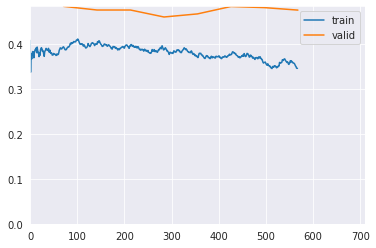

Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.20394736528396606.


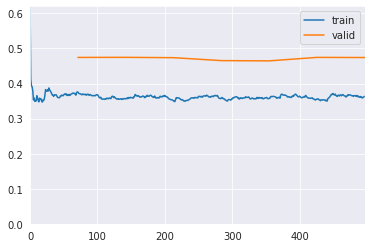

Better model found at epoch 0 with error_rate value: 0.21710526943206787.


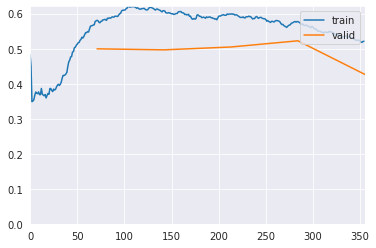

Better model found at epoch 1 with error_rate value: 0.19736842811107635.
Better model found at epoch 4 with error_rate value: 0.15789473056793213.


F1 score for this fold  0.8619318998132275


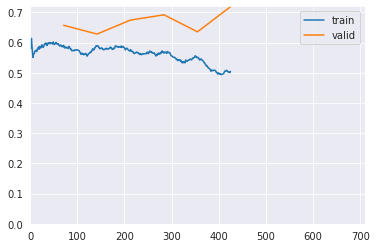

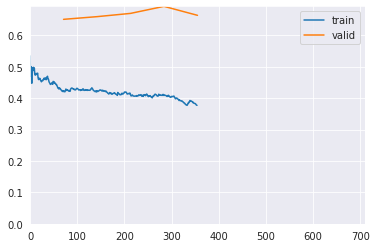

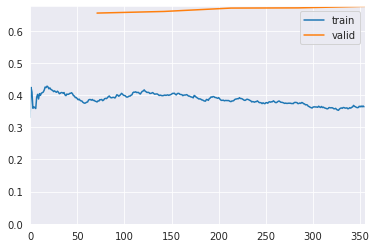

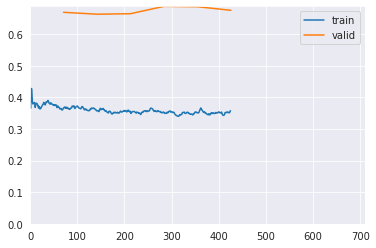

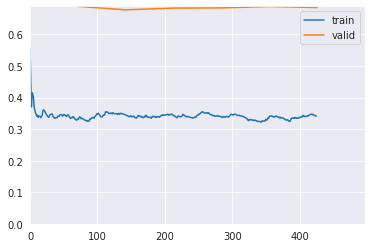

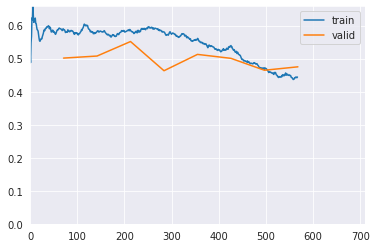

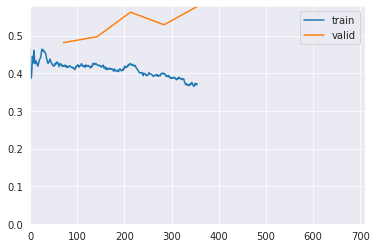

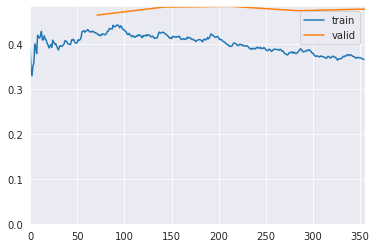

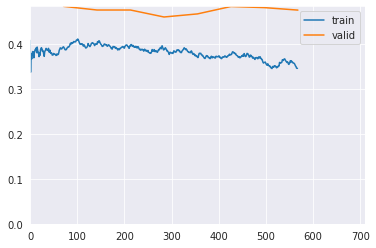

In [29]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.densenet169, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


## Resnet101

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Better model found at epoch 0 with error_rate value: 0.3486842215061188.


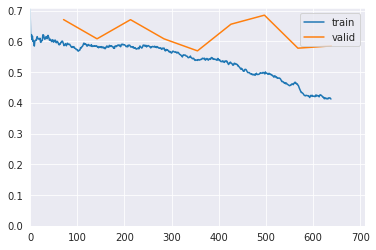

Better model found at epoch 1 with error_rate value: 0.29605263471603394.
Better model found at epoch 3 with error_rate value: 0.28947368264198303.
Better model found at epoch 8 with error_rate value: 0.28289473056793213.
Epoch 8: early stopping


Better model found at epoch 0 with error_rate value: 0.29605263471603394.


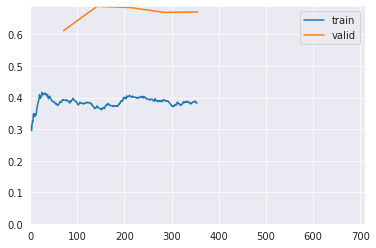

Better model found at epoch 1 with error_rate value: 0.2763157784938812.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.28289473056793213.


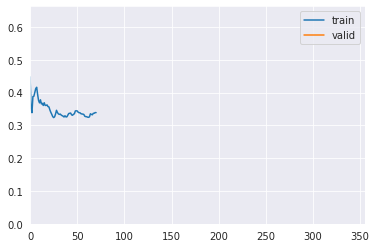

Better model found at epoch 1 with error_rate value: 0.2565789520740509.


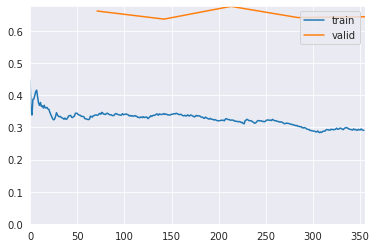

Better model found at epoch 0 with error_rate value: 0.2697368562221527.


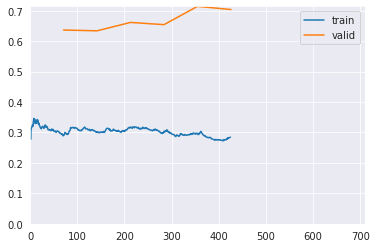

Better model found at epoch 2 with error_rate value: 0.2565789520740509.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.2565789520740509.


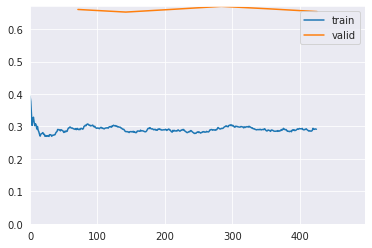

Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.43421053886413574.


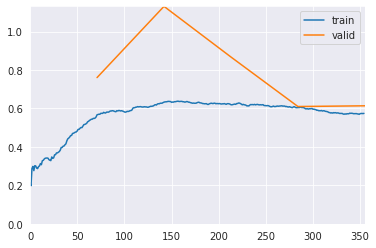

Better model found at epoch 2 with error_rate value: 0.42763158679008484.
Better model found at epoch 3 with error_rate value: 0.32236841320991516.


F1 score for this fold  0.6712235133287765


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.22368420660495758.


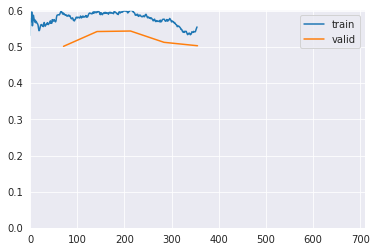

Better model found at epoch 3 with error_rate value: 0.19736842811107635.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.2368421107530594.


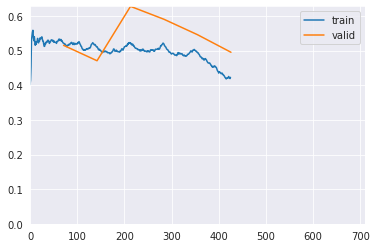

Better model found at epoch 1 with error_rate value: 0.21052631735801697.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.19078947603702545.


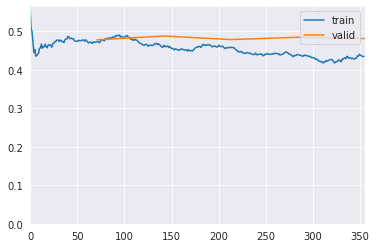

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.18421052396297455.


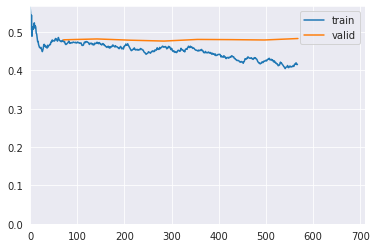

Better model found at epoch 7 with error_rate value: 0.17763157188892365.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.21052631735801697.


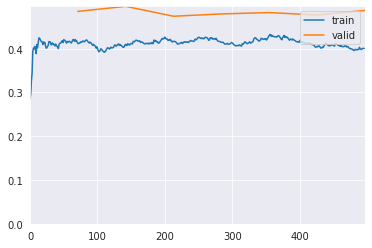

Better model found at epoch 1 with error_rate value: 0.20394736528396606.
Better model found at epoch 2 with error_rate value: 0.17105263471603394.
Epoch 6: early stopping


Better model found at epoch 0 with error_rate value: 0.5921052694320679.


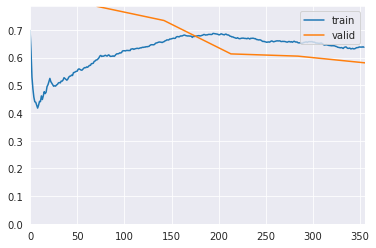

Better model found at epoch 1 with error_rate value: 0.4934210479259491.
Better model found at epoch 2 with error_rate value: 0.30921053886413574.
Better model found at epoch 4 with error_rate value: 0.2697368562221527.


F1 score for this fold  0.736979000301169


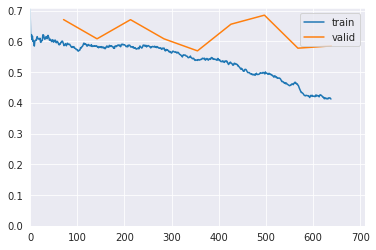

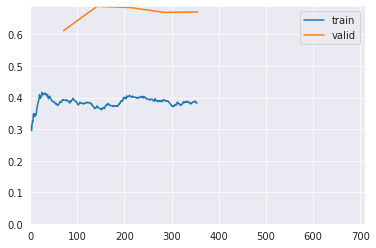

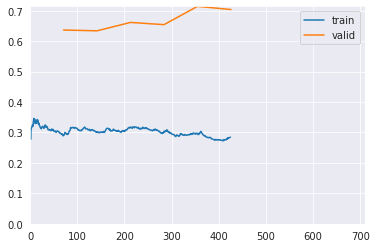

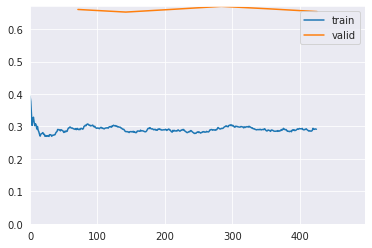

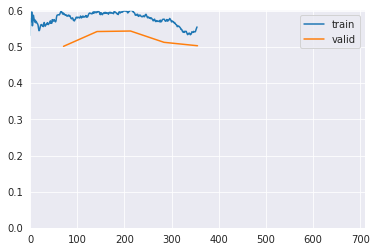

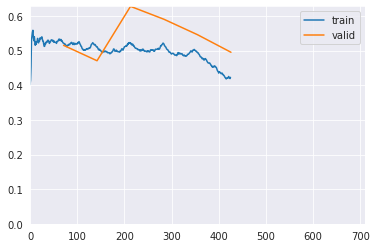

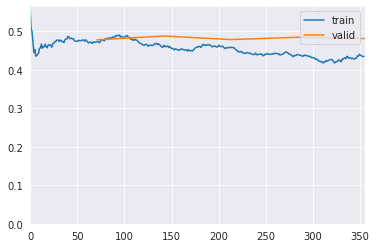

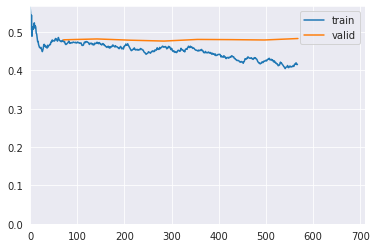

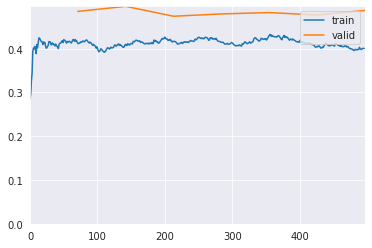

In [40]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.resnet101, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_res_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_res_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


##VGG16

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


Better model found at epoch 0 with error_rate value: 0.3618420958518982.


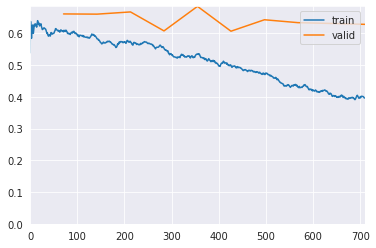

Better model found at epoch 1 with error_rate value: 0.3552631437778473.
Better model found at epoch 2 with error_rate value: 0.34210526943206787.
Better model found at epoch 3 with error_rate value: 0.33552631735801697.
Better model found at epoch 5 with error_rate value: 0.29605263471603394.
Epoch 9: early stopping


Better model found at epoch 0 with error_rate value: 0.28947368264198303.


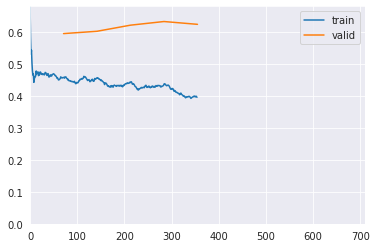

Better model found at epoch 1 with error_rate value: 0.28289473056793213.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.2697368562221527.


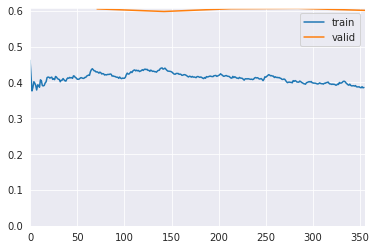

Better model found at epoch 0 with error_rate value: 0.2697368562221527.


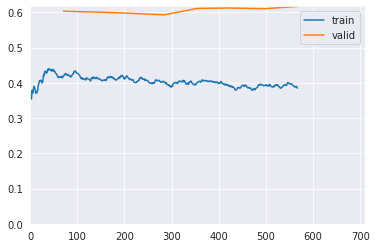

Better model found at epoch 1 with error_rate value: 0.2631579041481018.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.29605263471603394.


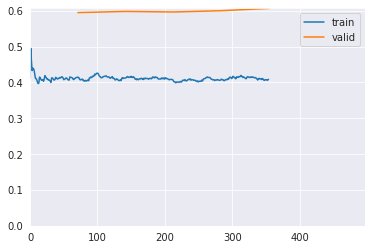

Better model found at epoch 1 with error_rate value: 0.28289473056793213.
Better model found at epoch 2 with error_rate value: 0.2763157784938812.
Better model found at epoch 3 with error_rate value: 0.2697368562221527.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.42105263471603394.


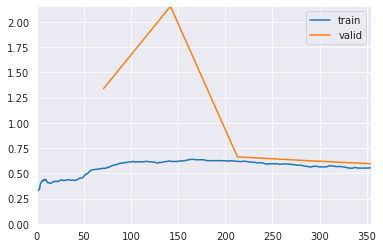

Better model found at epoch 2 with error_rate value: 0.3486842215061188.
Better model found at epoch 4 with error_rate value: 0.31578946113586426.


F1 score for this fold  0.6710526315789473


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.2763157784938812.


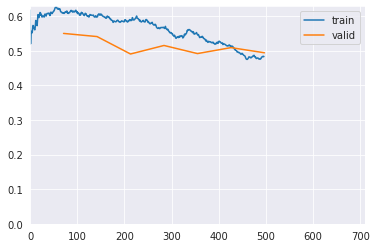

Better model found at epoch 1 with error_rate value: 0.2434210479259491.
Better model found at epoch 2 with error_rate value: 0.21710526943206787.
Better model found at epoch 3 with error_rate value: 0.20394736528396606.
Epoch 6: early stopping


Better model found at epoch 0 with error_rate value: 0.2631579041481018.


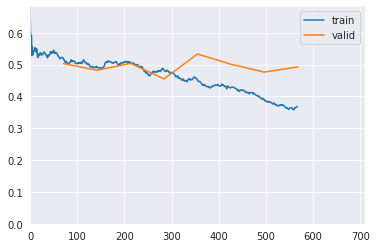

Better model found at epoch 1 with error_rate value: 0.19078947603702545.
Better model found at epoch 3 with error_rate value: 0.15789473056793213.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.18421052396297455.


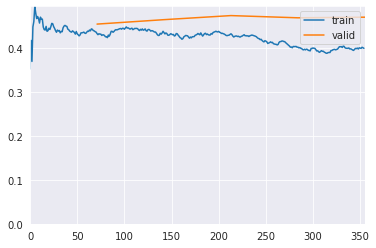

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.17763157188892365.


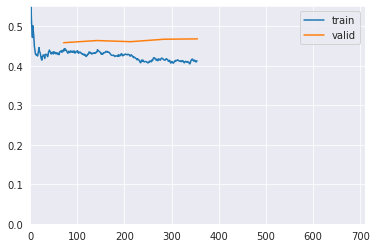

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.17763157188892365.


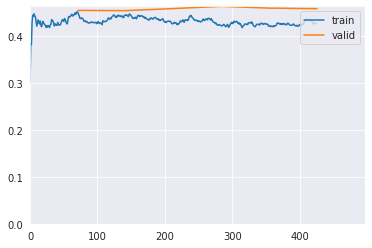

Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.46710526943206787.


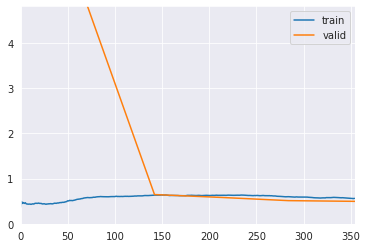

Better model found at epoch 1 with error_rate value: 0.3684210479259491.
Better model found at epoch 2 with error_rate value: 0.30921053886413574.
Better model found at epoch 3 with error_rate value: 0.2434210479259491.
Better model found at epoch 4 with error_rate value: 0.19736842811107635.


F1 score for this fold  0.8026315789473685


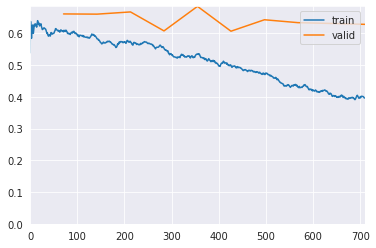

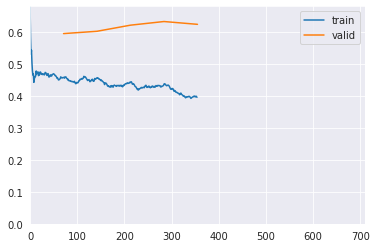

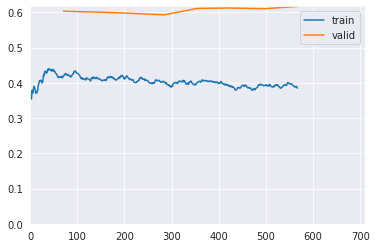

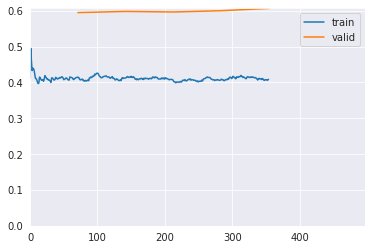

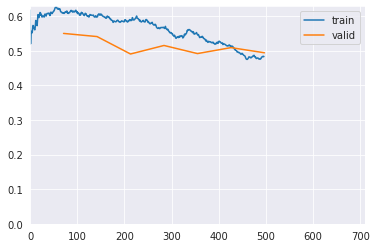

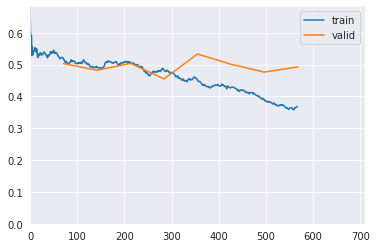

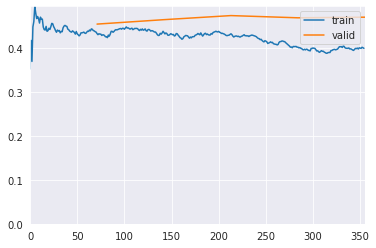

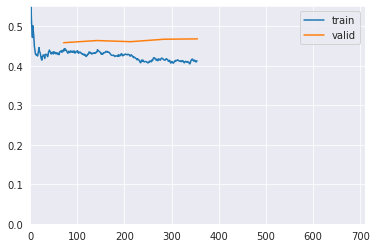

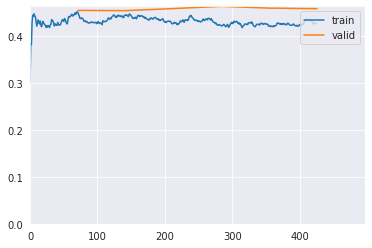

In [67]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.vgg16_bn, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

## VGG19

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Better model found at epoch 0 with error_rate value: 0.28289473056793213.


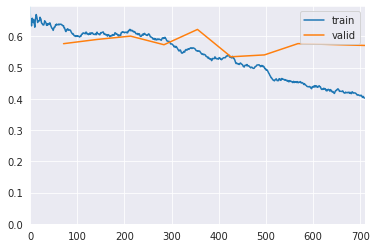

Better model found at epoch 1 with error_rate value: 0.2631579041481018.
Better model found at epoch 5 with error_rate value: 0.19736842811107635.
Epoch 9: early stopping


Better model found at epoch 0 with error_rate value: 0.23026315867900848.


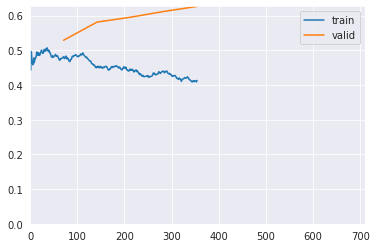

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.22368420660495758.


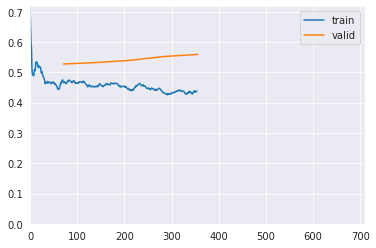

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.22368420660495758.


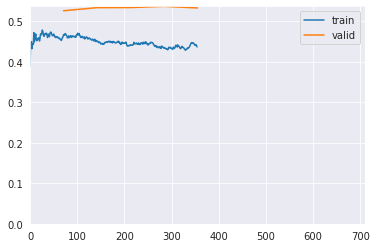

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.22368420660495758.


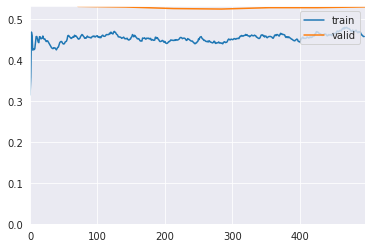

F1 score for this fold  0.7825830075776833


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.30263158679008484.


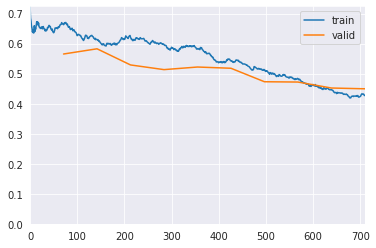

Better model found at epoch 1 with error_rate value: 0.29605263471603394.
Better model found at epoch 2 with error_rate value: 0.22368420660495758.
Better model found at epoch 8 with error_rate value: 0.20394736528396606.


Better model found at epoch 0 with error_rate value: 0.2434210479259491.


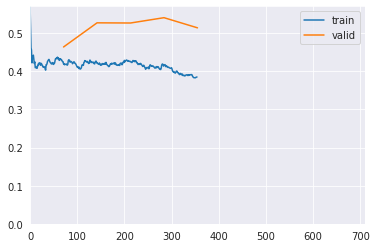

Better model found at epoch 1 with error_rate value: 0.21710526943206787.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.19078947603702545.


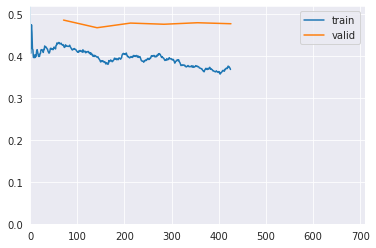

Better model found at epoch 3 with error_rate value: 0.17763157188892365.
Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.17763157188892365.


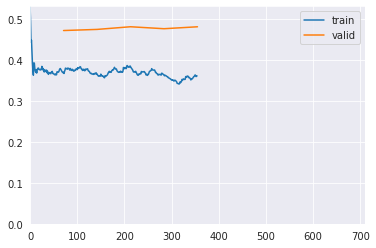

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.17105263471603394.


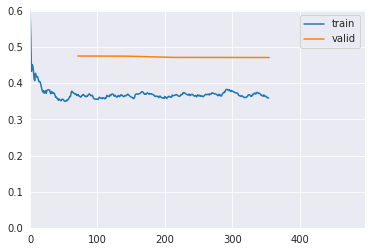

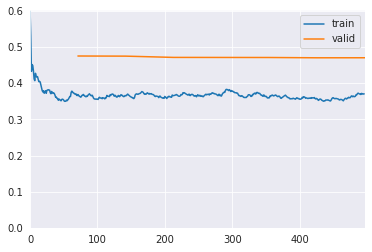

F1 score for this fold  0.8218649960414444


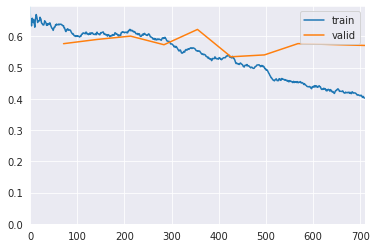

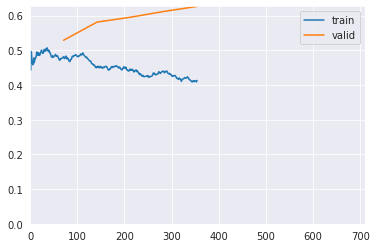

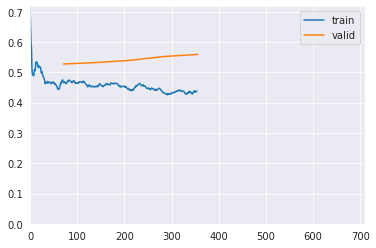

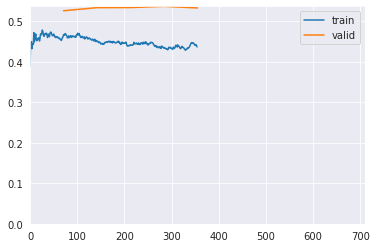

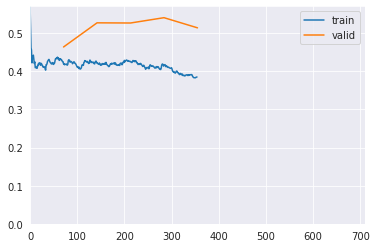

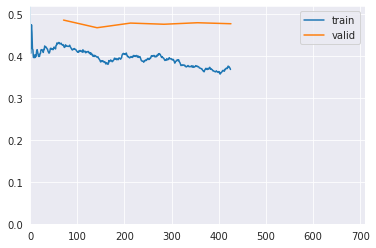

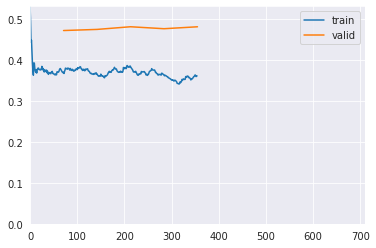

In [ ]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.vgg19_bn, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


## Densenet201

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


Better model found at epoch 0 with error_rate value: 0.29605263471603394.


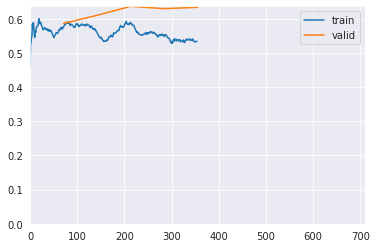

Better model found at epoch 1 with error_rate value: 0.28289473056793213.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.31578946113586426.


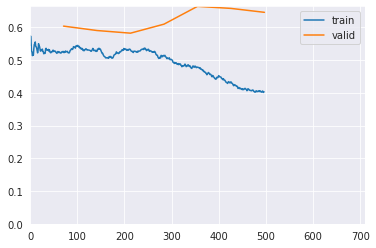

Better model found at epoch 1 with error_rate value: 0.29605263471603394.
Better model found at epoch 2 with error_rate value: 0.28947368264198303.
Better model found at epoch 6 with error_rate value: 0.2697368562221527.
Epoch 6: early stopping


Better model found at epoch 0 with error_rate value: 0.2565789520740509.


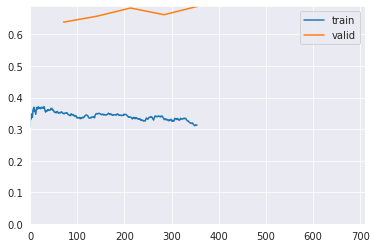

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.2565789520740509.


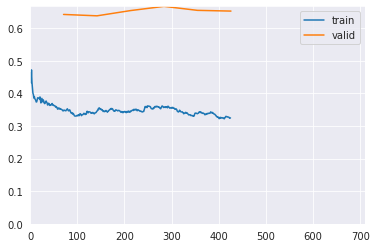

Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.2631579041481018.


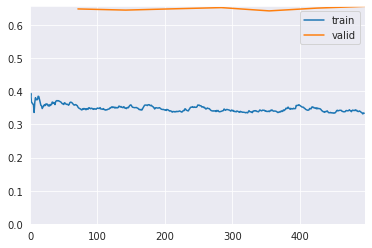

F1 score for this fold  0.7370244738665792


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.2697368562221527.


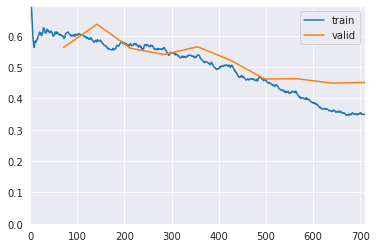

Better model found at epoch 3 with error_rate value: 0.21052631735801697.
Better model found at epoch 7 with error_rate value: 0.19736842811107635.
Better model found at epoch 8 with error_rate value: 0.16447368264198303.


Better model found at epoch 0 with error_rate value: 0.17105263471603394.


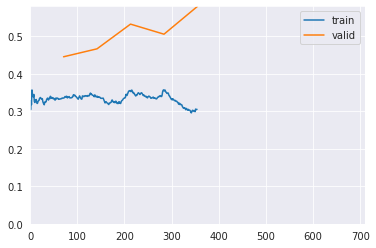

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.17763157188892365.


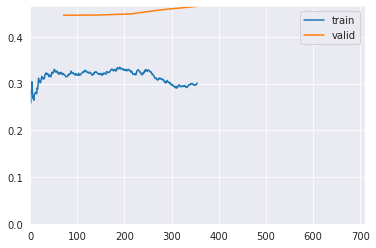

Better model found at epoch 4 with error_rate value: 0.17105263471603394.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.18421052396297455.


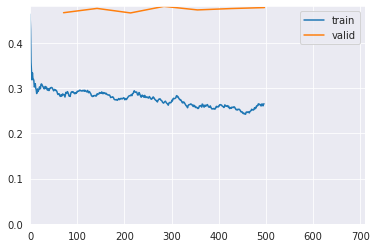

Better model found at epoch 1 with error_rate value: 0.17105263471603394.
Better model found at epoch 2 with error_rate value: 0.16447368264198303.
Epoch 6: early stopping


Better model found at epoch 0 with error_rate value: 0.16447368264198303.


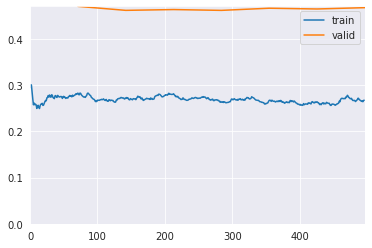

Better model found at epoch 1 with error_rate value: 0.15789473056793213.


F1 score for this fold  0.8287986528658632


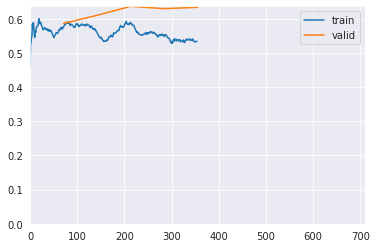

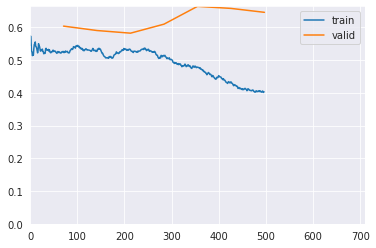

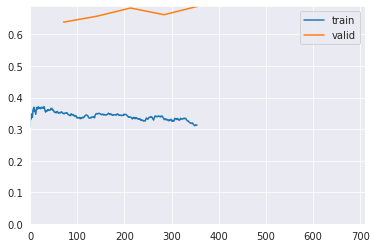

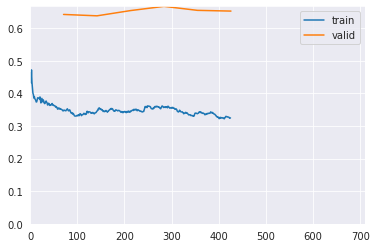

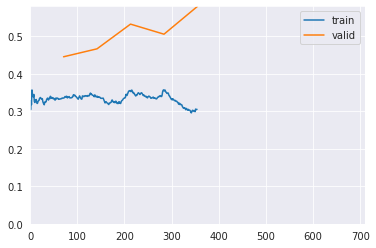

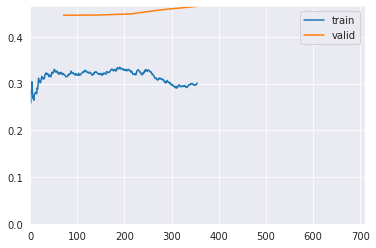

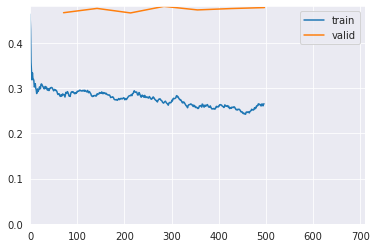

In [85]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.densenet201, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


## densenet161

(2425, 2) (606, 1)
Starting fold 0
(2273,) (152,)


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


Better model found at epoch 0 with error_rate value: 0.30921053886413574.


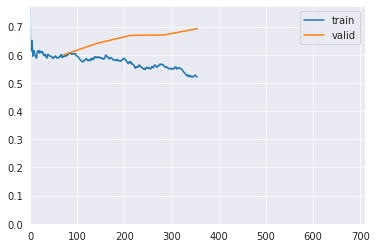

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.29605263471603394.


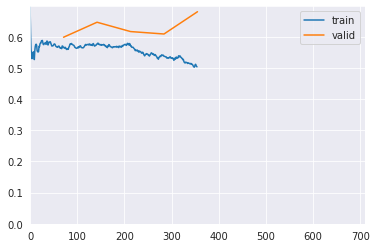

Better model found at epoch 2 with error_rate value: 0.28947368264198303.
Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.32236841320991516.


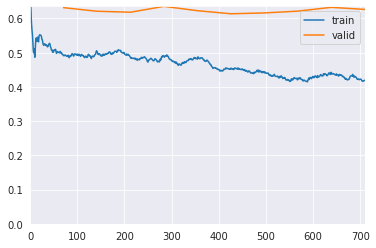

Better model found at epoch 1 with error_rate value: 0.29605263471603394.
Better model found at epoch 6 with error_rate value: 0.2763157784938812.
Epoch 9: early stopping


Better model found at epoch 0 with error_rate value: 0.2763157784938812.


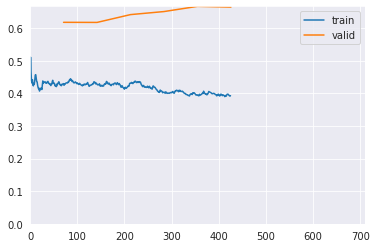

Epoch 5: early stopping


Better model found at epoch 0 with error_rate value: 0.2697368562221527.


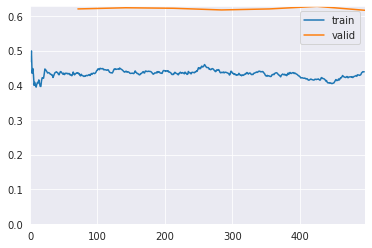

F1 score for this fold  0.710676900331286


Starting fold 1
(2273,) (152,)


Better model found at epoch 0 with error_rate value: 0.22368420660495758.


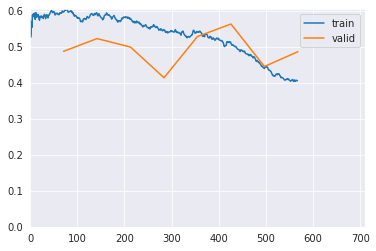

Better model found at epoch 3 with error_rate value: 0.16447368264198303.
Epoch 7: early stopping


Better model found at epoch 0 with error_rate value: 0.16447368264198303.


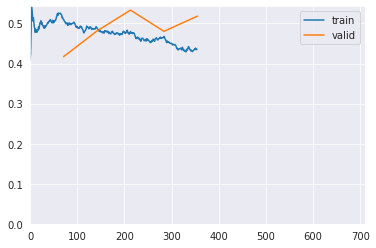

Epoch 4: early stopping


Better model found at epoch 0 with error_rate value: 0.17105263471603394.


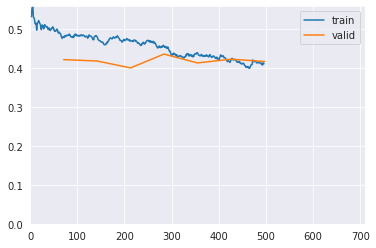

Better model found at epoch 1 with error_rate value: 0.15131579339504242.
Epoch 6: early stopping


Better model found at epoch 0 with error_rate value: 0.16447368264198303.


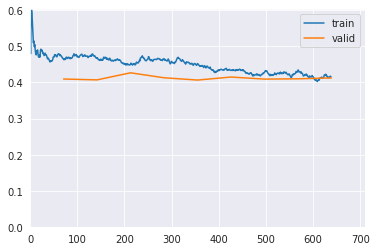

Better model found at epoch 1 with error_rate value: 0.15789473056793213.
Epoch 8: early stopping


Better model found at epoch 0 with error_rate value: 0.16447368264198303.


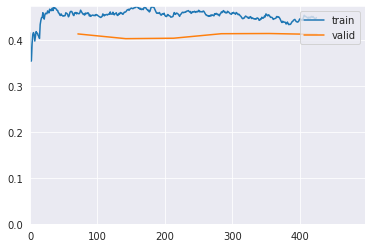

Epoch 5: early stopping


F1 score for this fold  0.8156299840510366


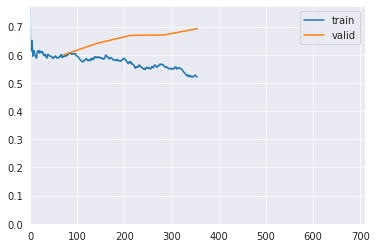

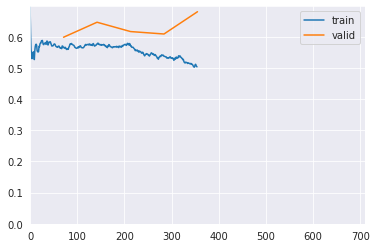

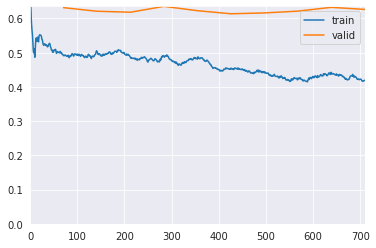

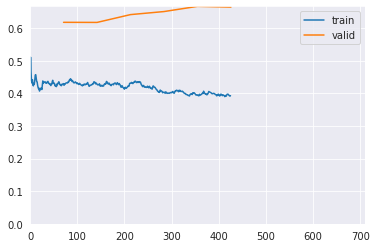

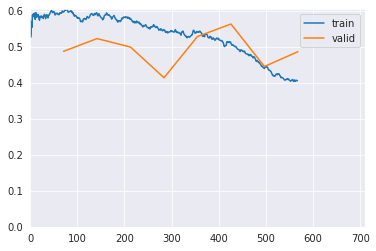

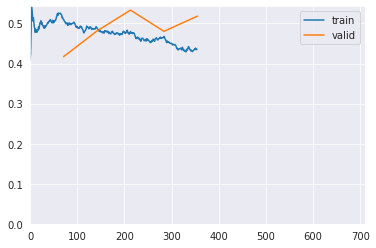

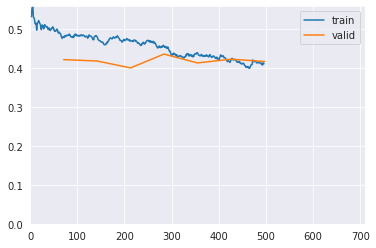

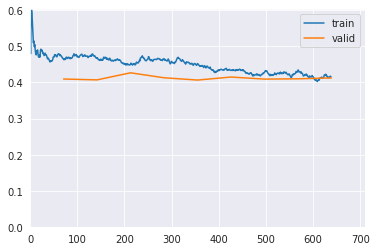

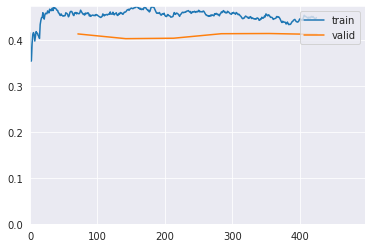

In [147]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT).split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        #learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        learn = cnn_learner(data, models.densenet161, metrics=[error_rate,accuracy,fscore], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        #cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=1e-5, callbacks=cb)
        learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


In [ ]:
test_preds

array([[1.066826, 2.548009],
       [1.978164, 1.374144],
       [1.85742 , 1.463472],
       [1.563052, 1.739086],
       ...,
       [1.164729, 2.333833],
       [1.121486, 2.423821],
       [1.315787, 2.065899],
       [1.198104, 2.26882 ]], dtype=float32)

In [148]:
sub = test_df[["filename"]]
sub["label"] = np.argmax(test_preds, axis=1)

In [149]:
sub['label'] = sub['label'].apply(lambda x : val[x])

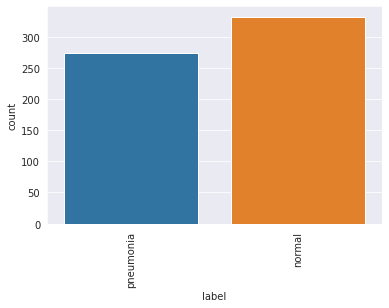

In [ ]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.show()

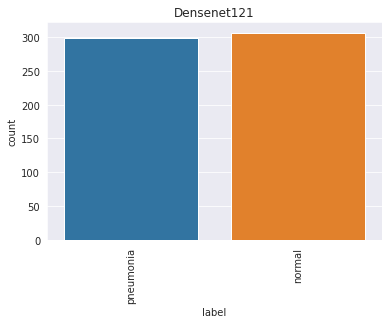

In [22]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('Densenet121')
plt.show()

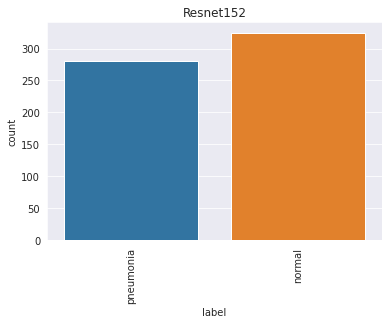

In [27]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('Resnet152')
plt.show()

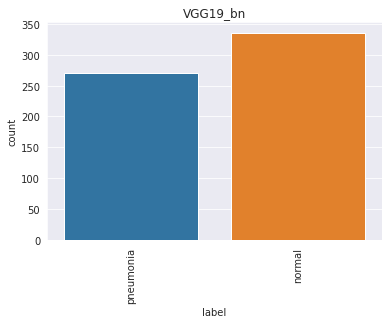

In [ ]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('VGG19_bn')
plt.show()

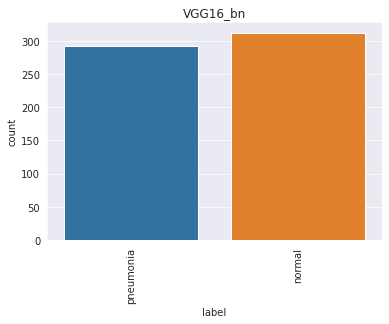

In [70]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('VGG16_bn')
plt.show()

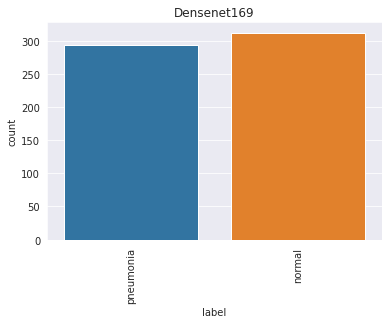

In [33]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('Densenet169')
plt.show()

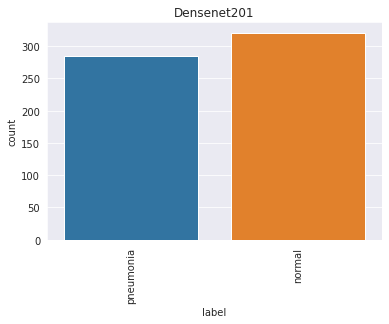

In [88]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('Densenet201')
plt.show()

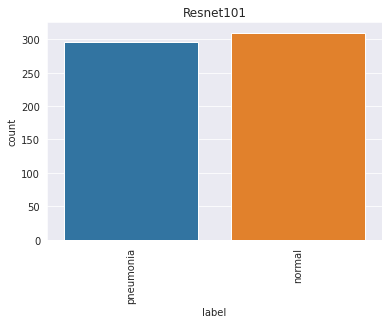

In [43]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('Resnet101')
plt.show()

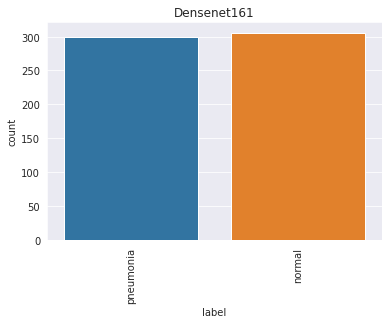

In [150]:
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(x='label',data=sub)
plt.title('Densenet161')
plt.show()

In [151]:
sub.to_csv("submission_den161callback.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_den161callback.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Results of score submission

**Submission successful! Your score is 78.62044210463343.- Densenet121-2 epochs each epoch having 10 fit cycles**

**Submission successful! Your score is 73.70659051720774.-Resnet152 2 epochs**

**Submission successful! Your score is 75.2579335839853.Vgg19 2 epochs**

**Submission successful! Your score is Submission successful! Your score is 76.66011940051655. Densenet121 callbacks**

**Submission successful! Your score is 74.49622711928356. Vgg19 callbacks***

**Submission successful! Your score is 74.67344680087342 Vgg16 calbacks.**

**Submission successful! Your score is 76.64694445275344.-Densenet169 callbacks**

**Submission successful! Your score is 73.65498454607365.Densenet201**

**Submission successful! Your score is 75.30859821676390-Densenet161**

## Using Majority Voting approach

In [152]:
df_152 = pd.read_csv("/content/submission_res152callback.csv")
df_121 = pd.read_csv("/content/submission_densecallback.csv")
df_169 = pd.read_csv("/content/submission_dense169callback.csv")
df_19 =  pd.read_csv("/content/submission_vgg19_callback.csv")
df_16 = pd.read_csv("/content/submission_vgg16callback.csv")
df_201 = pd.read_csv("/content/submission_den201callback.csv")
df_161 = pd.read_csv("/content/submission_den161callback.csv")

In [125]:
df_152.head()

filename      label
0  CXR_test_519.png  pneumonia
1  CXR_test_578.png     normal
2  CXR_test_359.png     normal
3  CXR_test_573.png  pneumonia
4  CXR_test_471.png  pneumonia

In [153]:
df_152 = df_152.rename(columns={'label':'p152'})
df_121 = df_121.rename(columns={'label':'p121'})
df_169 = df_169.rename(columns={'label':'p169'})
df_161 = df_161.rename(columns={'label':'p161'})
#df_19 = df_19.rename(columns={'label':'p19'})
#df_16 = df_16.rename(columns={'label':'p16'})
df_201 = df_201.rename(columns={'label':'p201'})


In [154]:
v_152 = df_152['p152'].values.tolist()
v_121= df_121['p121'].values.tolist()
v_169 = df_169['p169'].values.tolist()
v_161 = df_161['p161'].values.tolist()
v_201 = df_201['p201'].values.tolist()


In [155]:
df = pd.DataFrame({'p121':v_121,'p169':v_169,'p161':v_161})
df.head()

p121       p169       p161
0  pneumonia  pneumonia  pneumonia
1     normal     normal     normal
2     normal     normal     normal
3  pneumonia  pneumonia  pneumonia
4     normal     normal     normal

In [156]:
df['label'] = df.mode(axis=1)[0]

In [157]:
df.head()

p121       p169       p161      label
0  pneumonia  pneumonia  pneumonia  pneumonia
1     normal     normal     normal     normal
2     normal     normal     normal     normal
3  pneumonia  pneumonia  pneumonia  pneumonia
4     normal     normal     normal     normal

In [132]:
df_121.head()

filename       p121
0  CXR_test_519.png  pneumonia
1  CXR_test_578.png     normal
2  CXR_test_359.png     normal
3  CXR_test_573.png  pneumonia
4  CXR_test_471.png     normal

In [159]:
df_121['label'] = df.label.values.tolist()

In [160]:
df_121.head()

filename       p121      label
0  CXR_test_519.png  pneumonia  pneumonia
1  CXR_test_578.png     normal     normal
2  CXR_test_359.png     normal     normal
3  CXR_test_573.png  pneumonia  pneumonia
4  CXR_test_471.png     normal     normal

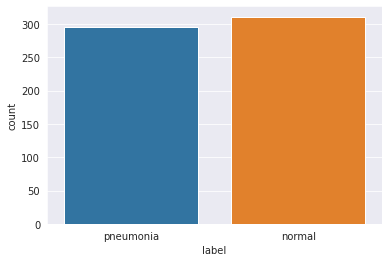

In [161]:
sns.countplot(x='label',data=df_121)

Text(0.5, 1.0, 'included_vgg16')

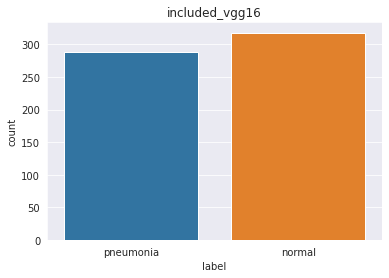

In [83]:
sns.countplot(x='label',data=df_121)
plt.title('included_vgg16')

Text(0.5, 1.0, 'included_dense201')

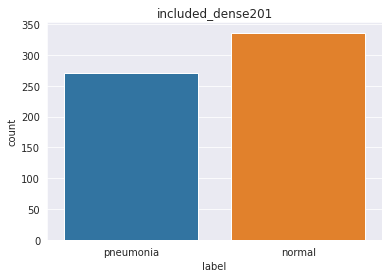

In [98]:
sns.countplot(x='label',data=df_121)
plt.title('included_dense201')

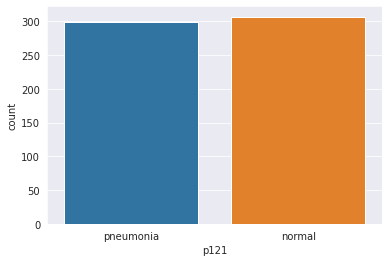

In [99]:
sns.countplot(x='p121',data=df_121)

In [162]:
df_121[['filename','label']].to_csv('majority_voting_6.csv',index=False)

**Submission successful! Your score is 77.49026707001093.-ensemble(121,152,169,vgg19)**

**Submission successful! Your score is 76.53486787959156.(121,152,169,vgg19,vgg16,201)**

**Submission successful! Your score is 76.53486787959156.(121,152,169,vgg19,VGG16,201)**

**Submission successful! Your score is 76.87667089094849.(121,152,169,201)**

**Submission successful! Your score is 76.97133841429171.(121,169,161)**

**Submission successful! Your score is 79.21666421054765. majority voting(121,169)**